<h1> <a href=http://www.datascience-paris-saclay.fr/>Paris Saclay Center for Data Science</a> </h1>

<h2> <a href=http://www.ramp.studio/problems/drug_spectra>RAMP</a> on qualitative and quantitative non-invasive monitoring of anti-cancer drugs </h2>

<i>Camille Marini (LTCI/CNRS), Alex Gramfort (LTCI/Télécom ParisTech), Sana Tfaili (Lip(Sys)²/UPSud), Laetitia Le (Lip(Sys)²/UPSud), Mehdi Cherti (LAL/CNRS), Balázs Kégl (LAL/CNRS)</i>

<h2> Introduction </h2>

<p>Chemotherapy is one of the most used treatment against cancer. It uses chemical substances (<a href=https://en.wikipedia.org/wiki/List_of_chemotherapeutic_agents>chemotherapeutic agents</a>) which kill cells that divide too quickly. These chemical substances are often diluted in a particular solution and packaged in bags, diffusers, or syringes, before being administered. <a href=https://books.google.fr/books?id=EB00rD8AqaYC&pg=PA188&lpg=PA188&dq=wrong+chemotherapeutic&source=bl&ots=m7EfyG6A3J&sig=ZVa0hLqDPFe2iExV6FOREJztN8c&hl=en&sa=X&ved=0ahUKEwj_5ZinkarMAhUFnBoKHaJiAgAQ6AEIKDAC#v=onepage&q=wrong%20chemotherapeutic&f=false>Wrong medication</a>  (wrong chemotherapeutic agent or wrong concentration) can have major impacts for patients. To prevent wrong medication, some recent French regulations impose the verification of anti-cancer drugs before their administration. The goal is to check that they contain the good chemotherapeutic agent with the good dosage. 

<p><a href=https://en.wikipedia.org/wiki/Raman_spectroscopy>Raman spectroscopy</a> could be used to make this check, since, theoretically, i) each molecule has a specific spectral fingerprint by which the molecule can be identified; and ii) the Raman intensity increases with the concentration of the molecule. The main advantage of spectroscopy above other methods (for example, liquid chromatography) is that it is non-destructive and non-invasive (measures are made without opening the drug containers). However, this method is rarely used in hospital environment because of the complexity of the spectral signals to analyze. Automating the analysis of these spectral signals could significantly help. Eventually, a complete analytical system (from measuring Raman spectra to identifying the chemotherapeutic agent and its concentration) could be designed, which would be easy to use and would prevent wrong medication. 

<p>In this context, the goal of this project is to develop prediction models able to <b>identify and quantify chemotherapeutic agents from their Raman spectra</b>.  

<p>The Lip(Sys)² laboratory measured Raman spectra of 4 types of chemotherapeutic agents (called <i>molecule</i>) in 3 different packages (called <i>vial</i>), diluted in 9 different solutions (called <i>solute gammes</i>), and having different concentrations. A total of <b>360 spectra were measured for each agent</b>, except for one (348 spectra).<br>  

Part of these data are saved in the file <code>train.csv</code> as follows (<code>n_samples</code> being the number of samples): 
<ul>
    <li><b>molecule</b>: Type of chemotherapeutic agent. Six possible values: A for infliximab, B for bévacizumab, Q for ramucirumab, R for rituximab. Dimension: (<code>n_samples</code>,)</li>
    <li><b>vial</b>: Vial type. Three possible values: 1, 2, 3. Dimension: (<code>1</code>, <code>n_samples</code>)</li>
    <li><b>solute</b>: Solute group. Fourteen possible values: 1, 2, ..., 14. Dimension: (<code>1</code>, <code>n_samples</code>)</li>
    <li><b>concentration</b>: Concentration of the molecule. Dimension: (<code>n_samples</code>, <code>1</code>)</li>
    <li><b>spectra</b>: Intensity of Raman spectrum. Dimension: (<code>n_samples</code>, <code>1866</code>)</li>
</ul>

<p>To sum up, there are too objectives:

<ul>
    <li><b>classification</b>: predict which molecule it corresponds to given the spectrum.</li>
    <li><b>regression</b>: predict the concentration of a molecule. The prediction should not depend on the vial or the solute group. The error metric is the mean absolute relative error (mare): $$\frac{1}{n_{samples}}\sum_{i=1}^{n_{samples}}\left|\frac{y_i-\hat{y}_i}{y_i}\right|$$ with $y$ and $\hat{y}$ being the true and predicted concentration.</li>
</ul>

### Requirements

* numpy>=1.10.0  
* matplotlib>=1.5.0 
* pandas>=0.17.0  
* scikit-learn>=0.17 (different syntaxes for v0.17 and v0.18)   

In [29]:
%matplotlib inline
import os
import glob
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import pandas as pd

## Exploratory data analysis

### Loading the data

In [30]:
data = pd.read_csv('data/train.csv.bz2')

y_df = data[['molecule', 'concentration']]
X_df = data.drop(['molecule', 'concentration'], axis=1)
spectra = X_df['spectra'].values                                        
spectra = np.array([np.array(dd[1:-1].split(',')).astype(float) for dd in spectra])    
X_df['spectra'] = spectra.tolist()

The input contains two categorical columns, `solute` and `vial`, and the column `spectra` containing the spectrum mesured at 1866 frequencies.

In [31]:
X_df.head()

,solute,spectra,vial
0,6,"[0.0267469, 0.0272395, 0.0268747, 0.0267555, 0...",2
1,11,"[0.015715, 0.0157924, 0.015861, 0.0159583, 0.0...",3
2,3,"[0.0149651, 0.0149305, 0.0147155, 0.0149207, 0...",2
3,12,"[0.015805, 0.0159376, 0.0161405, 0.0159903, 0....",1
4,12,"[0.0220265, 0.0221564, 0.0221778, 0.0221323, 0...",1


The output has two columns, the classification target `molecule` and the regression target `concentration`.

In [32]:
y_df.head()

,molecule,concentration
0,B,20000
1,Q,6000
2,R,800
3,R,2000
4,R,10000


The 1866 frequencies at which the spectra are sampled.

In [33]:
freqs = pd.read_csv('freq.csv')
freqs = freqs['freqs'].values
len(freqs), freqs

(1866,
 array([  400.095,   402.626,   405.155, ...,  3996.41 ,  3997.88 ,  3999.36 ]))

The four molecule classes.

In [34]:
np.unique(y_df['molecule'].values)

array(['A', 'B', 'Q', 'R'], dtype=object)

In [35]:
# Target for classification
molecule = y_df['molecule'].values
# Target for regression
concentration = y_df['concentration'].values

### Some plots

#### Raman spectra

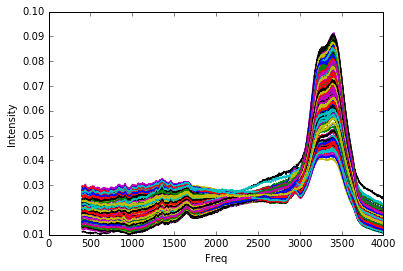

In [36]:
plt.plot(freqs, spectra.T)
plt.xlabel('Freq')
plt.ylabel('Intensity')

#### Distribution of concentrations

There are 21 different values of concentrations.


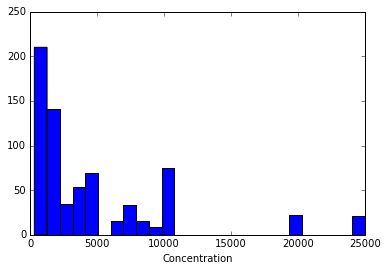

In [37]:
plt.hist(concentration, bins=26)
plt.xlabel('Concentration')
print("There are %s different values of concentrations." % np.unique(concentration).size)

[  300   400   600   800  1000  1400  1600  2000  5000 10000]
[  500  1000  1500  2000  4000  5000  7000 10000 20000 25000]
[ 1000  2000  3000  4000  5000  6000  7000  8000  9000 10000]
[  400   800  1000  1200  1600  2000  3000  4000  5000 10000]


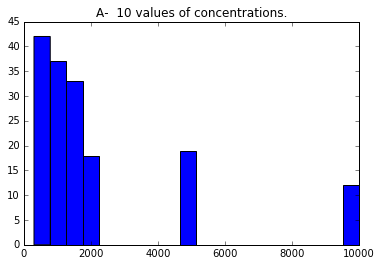

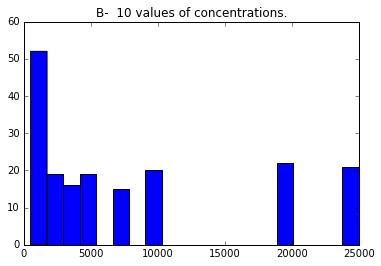

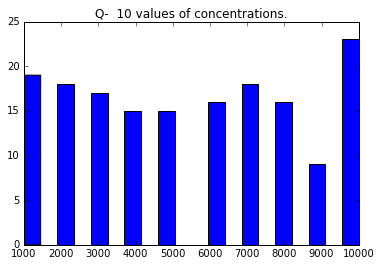

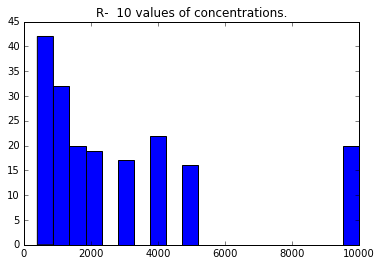

In [38]:
for mol in np.unique(molecule):
    plt.figure()
    plt.hist(concentration[molecule == mol], bins=20)
    plt.title(mol + "-  %s values of concentrations."
              % np.unique(concentration[molecule == mol]).size)
    print(np.unique(concentration[molecule == mol]))

#### Proportion of molecules

Number of samples: 699


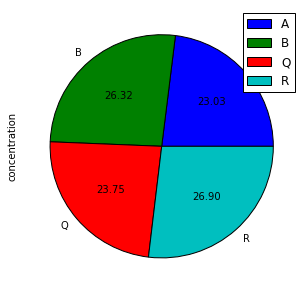

In [40]:
print('Number of samples: %s' % len(y_df))
y_df.groupby('molecule').count().plot(
    y='concentration', kind='pie', autopct='%.2f', figsize=(5, 5));

#### Proportion of solute groups and vial group

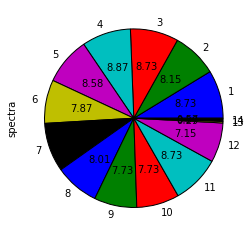

In [41]:
X_df.groupby('solute').count().plot(
    y='spectra', kind='pie', autopct='%.2f', figsize=(4, 4), legend=None);

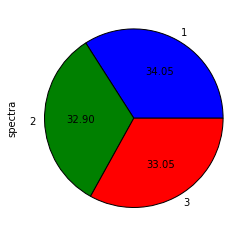

In [42]:
X_df.groupby('vial').count().plot(
    y='spectra', kind='pie',  autopct='%.2f', figsize=(4, 4), legend=None)

#### Mean Raman spectra for each concentration value

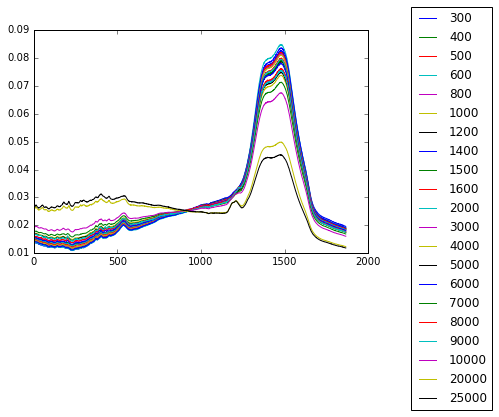

In [43]:
for c in np.unique(concentration):
    plt.plot(np.mean(spectra[concentration == c, :], axis=0), label="%s" % c)

plt.legend(bbox_to_anchor=(1.2, 1),
           bbox_transform=plt.gcf().transFigure);

#### Raman spectra for each type of molecule

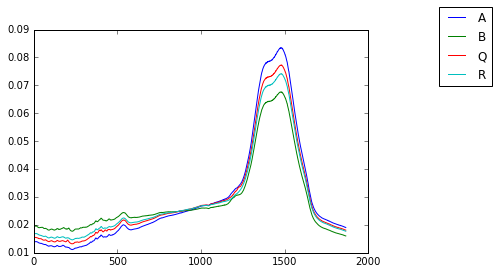

In [46]:
# Mean Raman spectra for each type of molecule
for mol in np.unique(molecule):
    plt.plot(np.mean(spectra[molecule == mol, :], axis=0), label="%s" % mol)

plt.legend(bbox_to_anchor=(1.2, 1),
           bbox_transform=plt.gcf().transFigure);

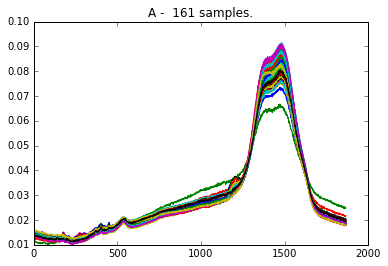

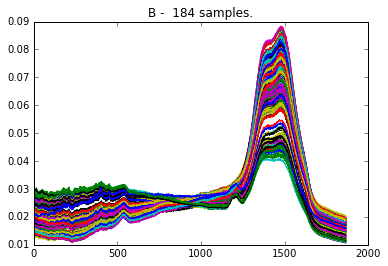

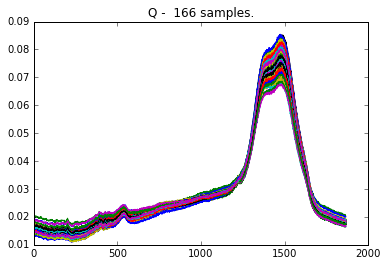

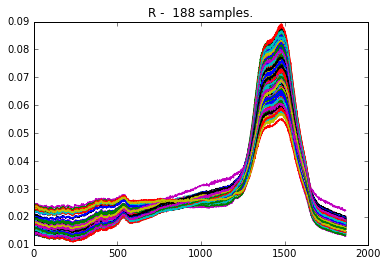

In [47]:
# For each molecule
for mol in np.unique(molecule):
    plt.figure()
    plt.plot(spectra[molecule == mol, :].T)
    plt.title(mol + " -  %s samples." % spectra[molecule == mol, :].shape[0]);

## The prediction task

The goal of the RAMP is to **classify each spectrum into one of the four molecule types**, and to **measure the concentration of the drugs**. The following sketch shows you the four preditive steps you will work on, inserted into the workflow.

<img src="workflow.png" style="width: 500px;"/>

Each submission will contain four classes, saved in four different files:   
* the `FeatureExtractor` in `feature_extractor_clf.py` will be used to extract features for classification from the dataset and produce a numpy array.  
* the `Classifier` in `classifier.py` will predict the molecule type.
* the `FeatureExtractor` in `feature_extractor_reg.py` will be used to extract features for regression from the dataset and produce a numpy array.  
* the `Regressor` in `regressor.py` will predict the drug concentration.

The first step is a feature extractor that takes the raw spectra and the two additional columns in an input data frame, and outputs features in a numpy array that will be used by the molecule classifier. The default feature extractor sends the full raw spectra to the classifier.

Note that the following code cells are *not* executed in the notebook. The notebook saves their contents in the file specified in the first line of the cell, so you can edit your submission before running the local test below and submitting it at the RAMP site.

In [26]:
%%file submissions/starting_kit/feature_extractor_clf.py
import numpy as np


class FeatureExtractor():
    def __init__(self):
        pass

    def fit(self, X_df, y):
        pass

    def transform(self, X_df):
        X_array = np.array([np.array(dd) for dd in X_df['spectra']])
        return X_array



Overwriting submissions/starting_kit/feature_extractor_clf.py


The classifier implements a classifier of the scikit-learn template. The default is a pipeline of a PCA followed by a random forest.

In [27]:
%%file submissions/starting_kit/classifier.py

from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator


class Classifier(BaseEstimator):
    def __init__(self):
        self.n_components = 100
        self.n_estimators = 10
        self.clf = Pipeline([
            ('pca', PCA(n_components=self.n_components)),
            ('clf', RandomForestClassifier(
                n_estimators=self.n_estimators, random_state=42))
        ])

    def fit(self, X, y):
        self.clf.fit(X, y)

    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)



Overwriting submissions/starting_kit/classifier.py


The feature extractor for the concentration regressor will receive the raw spectra and the two additional columns. In addition, since the regressor should know about _which_ molecule it estimates the concentration of, it will also receive four additional columns corresponding to the four molecule types. At train time we send the true label in a one-hot vector, and at test time we send the posterior probabilites that the `predict_proba` function of the classifier outputs. The default feature extractor normalizes the raw spectra and concatenates the four class posteriors to normalized spectra.

In [28]:
%%file submissions/starting_kit/feature_extractor_reg.py
import numpy as np

label_names = np.array(['A', 'B', 'Q', 'R'])


class FeatureExtractor():
    def __init__(self):
        pass

    def fit(self, X_df, y):
        pass

    def transform(self, X_df):
        X_array = np.array([np.array(dd) for dd in X_df['spectra']])
        X_array -= np.median(X_array, axis=1)[:, None]
        X_array /= np.sqrt(np.sum(X_array ** 2, axis=1))[:, None]
        X_array = np.concatenate([X_array, X_df[label_names].values], axis=1)
        return X_array



Overwriting submissions/starting_kit/feature_extractor_reg.py


The default regressor will learn four gradient boosting regressors, one for each molecule type. (Of course, when the classifier makes a mistake, the regressor measures the concnetration of the wrong molecule, so the regression performance my also depend on the quality of the classifier.) Another particularity is that we target the logarithm of the concentration (and exponentiate the raw `y_pred` in `predict`). This is a common practice when the quality is measured by the relative error.

In [29]:
%%file submissions/starting_kit/regressor.py
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
import numpy as np


class Regressor(BaseEstimator):
    def __init__(self):
        self.n_components = 10
        self.n_estimators = 40
        self.learning_rate = 0.2
        self.list_molecule = ['A', 'B', 'Q', 'R']
        self.dict_reg = {}
        for mol in self.list_molecule:
            self.dict_reg[mol] = Pipeline([
                ('pca', PCA(n_components=self.n_components)),
                ('reg', GradientBoostingRegressor(
                    n_estimators=self.n_estimators,
                    learning_rate=self.learning_rate,
                    random_state=42))
            ])

    def fit(self, X, y):
        for i, mol in enumerate(self.list_molecule):
            ind_mol = np.where(np.argmax(X[:, -4:], axis=1) == i)[0]
            X_mol = X[ind_mol]
            y_mol = y[ind_mol]
            self.dict_reg[mol].fit(X_mol, np.log(y_mol))

    def predict(self, X):
        y_pred = np.zeros(X.shape[0])
        for i, mol in enumerate(self.list_molecule):
            ind_mol = np.where(np.argmax(X[:, -4:], axis=1) == i)[0]
            X_mol = X[ind_mol]
            y_pred[ind_mol] = np.exp(self.dict_reg[mol].predict(X_mol))
        return y_pred



Overwriting submissions/starting_kit/regressor.py


## The scores

We evaluate the classifier by the [classification error](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/rampwf/score_types/classification_error.py) and the regression by the [mean absolute relative error (MARE)](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/rampwf/score_types/mare.py)

$$\frac{1}{n}\sum_{k=1}^{n}\left|\frac{y-\hat{y}}{y}\right|.$$

The *combined* score is a weighted some of these two. Since the classification performance is more important, we weight the classification error by $2/3$ and the MARE by $1/3$.

## Local testing (before submission)

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. For this we provide a unit test. Note that the test runs on your files in [`submissions/starting_kit`](http://localhost:8890/tree/submissions/starting_kit).

First `pip install ramp-workflow` or install it from the [github repo](https://github.com/paris-saclay-cds/ramp-workflow). Make sure that the python files `feature_extractor_clf.py`, `classifier.py`, `feature_extractor_reg.py`, and `regressor.py` are in the  [`submissions/starting_kit`](http://localhost:8890/tree/submissions/starting_kit) folder, and the data `train.csv.bz2` and `test.csv.bz2` are in [`data`](http://localhost:8890/tree/data). Then run

```ramp_test_submission```

If it runs and print training and test errors on each fold, then you can submit the code.

In [30]:
!ramp_test_submission

Testing Drug classification and concentration estimation from Raman spectra
Reading train and test files from ./data ...
Reading cv ...
Training ./submissions/starting_kit ...
/Users/kegl/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/kegl/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
CV fold 0
	train combined = 0.012
	valid combined = 0.199
	tes

Alternatively, load and execute `rampwf.utils.testing.py`, and call `assert_submission`. This may be useful if you would like to understand how we instantiate the workflow, the scores, the data connectors, and the cross validation scheme defined in [`problem.py`](problem.py), and how we insert and train/test your submission. To understand the workflow thoroughly, we suggest that you take a look at [drug spectra workflow implementation](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/rampwf/workflows/drug_spectra.py) which shows you the details of training and testing your models.

In [64]:
# %load https://raw.githubusercontent.com/paris-saclay-cds/ramp-workflow/master/rampwf/utils/testing.py



In [65]:
# assert_submission()

Testing Drug classification and concentration estimation from Raman spectra
Reading train and test files from .//data ...
Training .//submissions/starting_kit ...


/Users/kegl/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/kegl/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


CV fold 0
	train combined = 0.006
	valid combined = 0.175
	test combined = 0.185
	train error = 0.0
	valid error = 0.114
	test error = 0.147
	train mare = 0.017
	valid mare = 0.295
	test mare = 0.262
CV fold 1
	train combined = 0.006
	valid combined = 0.182
	test combined = 0.178
	train error = 0.0
	valid error = 0.15
	test error = 0.137
	train mare = 0.019
	valid mare = 0.246
	test mare = 0.262
CV fold 2
	train combined = 0.006
	valid combined = 0.197
	test combined = 0.19
	train error = 0.0
	valid error = 0.157
	test error = 0.157
	train mare = 0.019
	valid mare = 0.277
	test mare = 0.258
CV fold 3
	train combined = 0.006
	valid combined = 0.166
	test combined = 0.159
	train error = 0.0
	valid error = 0.136
	test error = 0.123
	train mare = 0.019
	valid mare = 0.226
	test mare = 0.229
CV fold 4
	train combined = 0.006
	valid combined = 0.13
	test combined = 0.159
	train error = 0.0
	valid error = 0.1
	test error = 0.117
	train mare = 0.019
	valid mare = 0.189
	test mare = 0.245
CV fo

## Submitting to [ramp.studio](http://ramp.studio)

Once you found a good model, you can submit it to [ramp.studio](http://www.ramp.studio). First, if it is your first time using RAMP, [sign up](http://www.ramp.studio/sign_up), otherwise [log in](http://www.ramp.studio/login). Then find an open event on the particular problem, for example, the event [drug spectra](https://www.ramp.studio/events/drug_spectra) for this RAMP. Sign up for the event. Both signups are controled by RAMP administrators, so there **can be a delay between asking for signup and being able to submit**.

Once your signup request is accepted, you can go to your [sandbox](http://www.ramp.studio/events/drug_spectra/sandbox) and copy-paste (or upload) [`feature_extractor_clf.py`](http://localhost:8890/edit/submissions/starting_kit/feature_extractor_clf.py), and [`classifier.py`](http://localhost:8890/edit/submissions/starting_kit/classifier.py), [`feature_extractor_reg.py`](http://localhost:8890/edit/submissions/starting_kit/feature_extractor_reg.py), and [`regressor.py`](http://localhost:8890/edit/submissions/starting_kit/regressor.py) from `submissions/starting_kit`. Save it, rename it, then submit it. The submission is trained and tested on our backend in the same way as `ramp_test_submission` does it locally. While your submission is waiting in the queue and being trained, you can find it in the "New submissions (pending training)" table in [my submissions](http://www.ramp.studio/events/drug_spectra/my_submissions). Once it is trained, you get a mail, and your submission shows up on the [public leaderboard](http://www.ramp.studio/events/drug_spectra/leaderboard). 
If there is an error (despite having tested your submission locally with `ramp_test_submission`), it will show up in the "Failed submissions" table in [my submissions](http://www.ramp.studio/events/drug_spectra/my_submissions). You can click on the error to see part of the trace.

After submission, do not forget to give credits to the previous submissions you reused or integrated into your submission.

The data set we use at the backend is usually different from what you find in the starting kit, so the score may be different.

The usual way to work with RAMP is to explore solutions, add feature transformations, select models, perhaps do some AutoML/hyperopt, etc., _locally_, and checking them with `ramp_test_submission`. The script prints mean cross-validation scores 
```
----------------------------
train combined = 0.006 ± 0.0004
train error = 0.0 ± 0.0
train mare = 0.019 ± 0.0011
valid combined = 0.17 ± 0.024
valid error = 0.135 ± 0.0298
valid mare = 0.24 ± 0.0259
test combined = 0.177 ± 0.015
test error = 0.142 ± 0.0203
test mare = 0.248 ± 0.0137
```
The official score in this RAMP (the first score column after "historical contributivity" on the [leaderboard](http://www.ramp.studio/events/drug_spectra/leaderboard)) is a weighted combination of "error" and "mare" ("combined"), so the line that is relevant in the output of `ramp_test_submission` is `valid mare = 0.24 ± 0.0259`. When the score is good enough, you can submit it at the RAMP.

## More information

You can find more information in the [README](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/README.md) of the [ramp-workflow library](https://github.com/paris-saclay-cds/ramp-workflow).

## Contact

Don't hesitate to [contact us](mailto:admin@ramp.studio?subject=drug spectra notebook).